In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader

from torchvision import datasets, transforms
import matplotlib.pyplot as plt

import Double_Pendulum.Lumped_Mass.robot_parameters as robot_parameters
import Double_Pendulum.Lumped_Mass.transforms as transforms
import Double_Pendulum.Lumped_Mass.dynamics as dynamics

In [2]:
rp = robot_parameters.LUMPED_PARAMETERS
print(rp)

{'l1': 2, 'l2': 2, 'm': 3, 'g': 9.81}


In [3]:
import numpy as np

# Number of samples
q1_low  = -torch.pi/2
q1_high =  torch.pi/2
q2_low  = -torch.pi/2
q2_high =  torch.pi/2

n_samples = 100000

# Generate uniformly distributed points for q1 and q2
q1 = torch.linspace(q1_low, q1_high, n_samples)
q2 = torch.linspace(q2_low, q2_high, n_samples)

idx = torch.randperm(q2.shape[0])

q2 = q2[idx]

# Stack q1 and q2 to get the 2D coordinates
points = torch.stack([q1, q2], axis=1)  # Shape will be (1000, 2)

In [4]:
# Use TensorDataset to create the dataset
dataset = TensorDataset(points)

# Create the DataLoader with batch size and shuffling
batch_size = 64
dataloader = DataLoader(dataset, 
                        batch_size=batch_size, 
                        shuffle=True,
                        num_workers=0,
                        pin_memory=True)


# Example usage: iterate through the DataLoader
for batch in dataloader:
    #print(batch)
    break  # Just to show one batch

/home/kian/anaconda3/envs/thesis/lib/python3.12/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [5]:
class SinCosLayer(nn.Module):
    def __init__(self):
        super(SinCosLayer, self).__init__()

    def forward(self, x):
        # Apply sin() and cos() to both coordinates
        x_sin = torch.sin(x)
        x_cos = torch.cos(x)
        x_sin_cos_shape = (x.shape[0], x.shape[1]*2)
        x_sin_cos = torch.empty(x_sin_cos_shape, dtype=x_sin.dtype, device=x.device)
        x_sin_cos[:,0::2] = x_sin
        x_sin_cos[:,1::2] = x_cos
        return x_sin_cos
    
# Custom layer to reverse the interleaved sin() and cos() back to original coordinates
class InverseSinCosLayer(nn.Module):
    def __init__(self):
        super(InverseSinCosLayer, self).__init__()

    def forward(self, x):
        # x contains interleaved sin() and cos() values
        # Assuming input is of shape (batch_size, 4) for 2D coordinates
        sin_vals = x[:, 0::2]  # Extract sin values
        cos_vals = x[:, 1::2]  # Extract cos values

        # Use atan2 to recover the original angles from sin and cos
        original_coords = torch.atan2(sin_vals, cos_vals)
        return original_coords
    



class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            #SinCosLayer(),
            nn.Linear(2, 4),
            nn.ReLU(),
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 2)#,
            #InverseSinCosLayer()
        )
        
        self.decoder = nn.Sequential(
            #SinCosLayer(),
            nn.Linear(2, 4),
            nn.ReLU(),
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 2)#,
            #InverseSinCosLayer()
        )
    
    def forward(self, q):
        theta = self.encoder(q)
        q_hat = self.decoder(theta)
        return(theta, q_hat)

In [8]:
%%time


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Autoencoder().to(device)  # Move model to GPU

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
#scheduler.get_last_lr()


num_epochs = 30
lambda_reg = 1e-4
outputs = []


for epoch in range(num_epochs):
    for (q) in dataloader:
        q = q[0].to(device)
        theta, q_hat = model(q)
        loss_reconstruction = criterion(q_hat, q)
        loss_theta = criterion(theta, q)
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        loss = loss_reconstruction + loss_theta #+ lambda_reg * l1_norm
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    scheduler.step()
    #print(scheduler.get_last_lr())
        
    print(f'Epoch:{epoch+1}, Loss:{loss.item():.9f}')
    print("l1 norm loss:", (l1_norm*lambda_reg).item())
    outputs.append((epoch, q, q_hat, theta))

Epoch:1, Loss:0.001842737
l1 norm loss: 0.009191105142235756
Epoch:2, Loss:0.000016655
l1 norm loss: 0.009257946163415909
Epoch:3, Loss:0.000015194
l1 norm loss: 0.009269359521567822
Epoch:4, Loss:0.000000721
l1 norm loss: 0.009265976026654243
Epoch:5, Loss:0.000001974
l1 norm loss: 0.00925093237310648
Epoch:6, Loss:0.000000360
l1 norm loss: 0.009229032322764397
Epoch:7, Loss:0.000000030
l1 norm loss: 0.009205803275108337
Epoch:8, Loss:0.000000144
l1 norm loss: 0.009166935458779335
Epoch:9, Loss:0.000000278
l1 norm loss: 0.009108340367674828
Epoch:10, Loss:0.000000440
l1 norm loss: 0.009025271050632
Epoch:11, Loss:0.000000069
l1 norm loss: 0.008924965746700764
Epoch:12, Loss:0.000000935
l1 norm loss: 0.008827723562717438
Epoch:13, Loss:0.000000072
l1 norm loss: 0.008741888217628002
Epoch:14, Loss:0.000000028
l1 norm loss: 0.00866974052041769
Epoch:15, Loss:0.000000053
l1 norm loss: 0.008614611811935902
Epoch:16, Loss:0.000000582
l1 norm loss: 0.008569825440645218
Epoch:17, Loss:0.00000

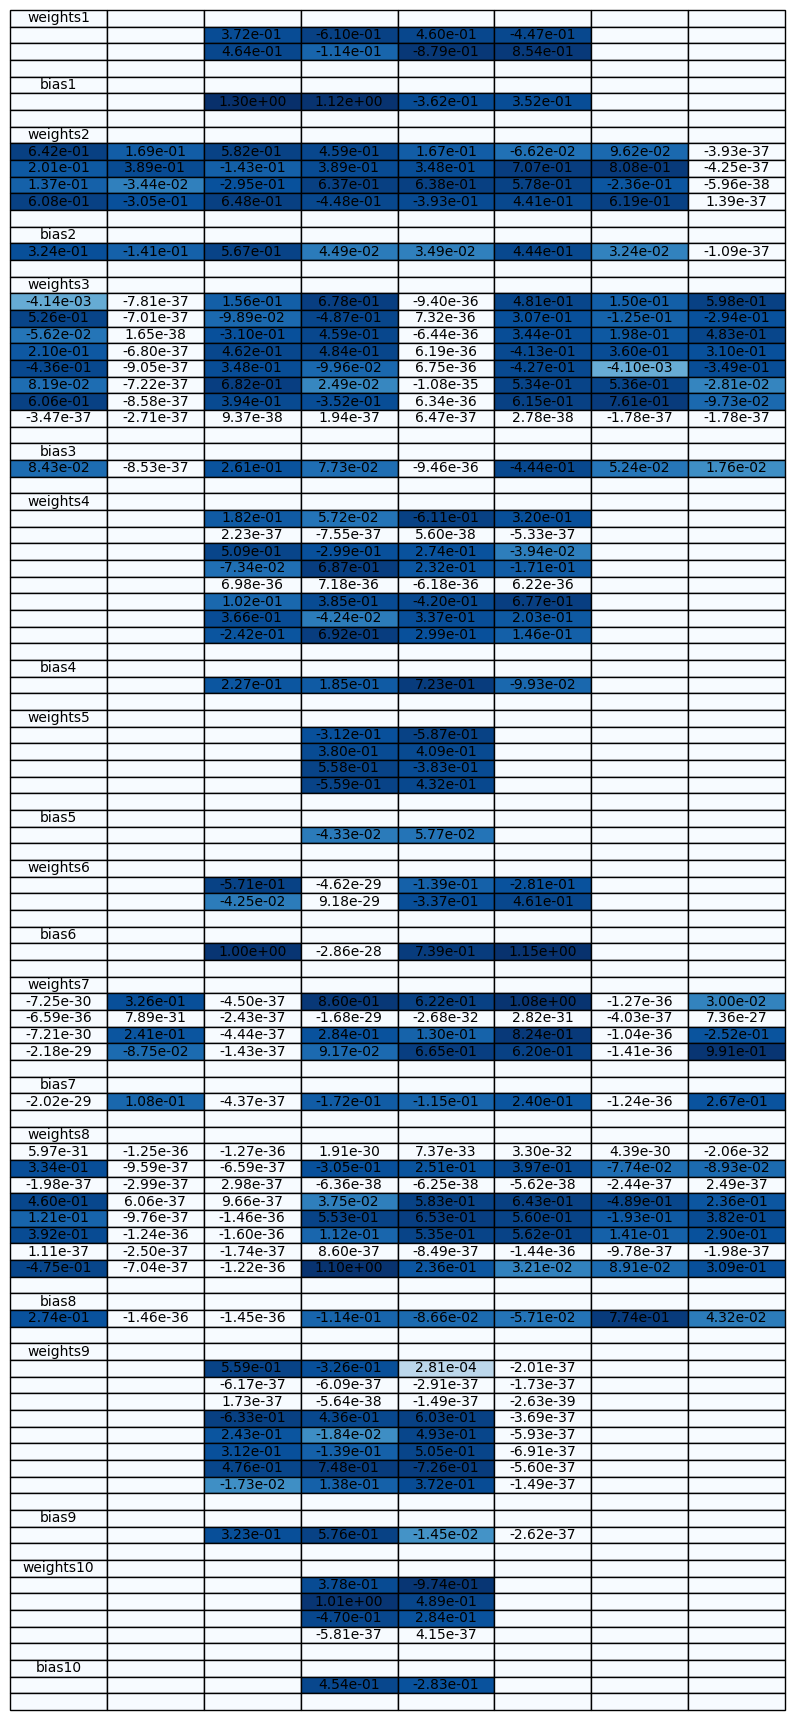

In [9]:
import random
import string

max_neurons = 8
blank_layer = [None for _ in range(max_neurons)]

table_layers = []
for idx, param in enumerate(model.parameters()):
    layer = param.data
    num_parallel = layer.shape[0]
    side_padding = int((max_neurons - num_parallel)/2)
    
    if idx % 2 == 0:
        
        table_layer = blank_layer.copy()
        table_layer[0] = "weights" + str(idx//2+1)
        table_layers.append(table_layer)
        for i in range(layer.shape[1]):
            table_layer = blank_layer.copy()
            for j in range(num_parallel):
                table_layer[j+side_padding] = '{:.2e}'.format(layer[j][i].item())
            table_layers.append(table_layer)
        table_layers.append(blank_layer)
            
    else:  
        
        table_layer = blank_layer.copy()
        table_layer[0] = "bias" + str(idx//2+1)
        table_layers.append(table_layer)
        table_layer = blank_layer.copy()
        for j in range(num_parallel):
            table_layer[j+side_padding] = '{:.2e}'.format(layer[j].item())
        table_layers.append(table_layer)
        table_layers.append(blank_layer)

numeric_values = np.zeros((len(table_layers), max_neurons))
for i, row in enumerate(table_layers):
    for j, item in enumerate(row):
        if item not in (None, "weights1", "weights2", "bias1", "bias2"):  # Replace with relevant layer names
            try:
                numeric_values[i, j] = (float(item))
            except ValueError:
                pass
        
min_val, max_val = numeric_values.min(), numeric_values.max()


# Step 2: Apply a logarithmic transformation, setting a small threshold to avoid log(0)
threshold = 1e-5
log_values = np.log10(np.clip(np.abs(numeric_values), threshold, None))

# Normalize the log-scaled values to range between 0 and 1
normalized_values = (log_values - log_values.min()) / (log_values.max() - log_values.min())
colors = plt.cm.Blues(normalized_values)

        
# Plot the table
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('tight')
ax.axis('off')

# Create table
table = plt.table(cellText=table_layers, cellColours=colors, loc='center', cellLoc='center')

plt.show()